<a href="https://colab.research.google.com/github/dmosh/deeplearning/blob/main/imageclassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#importing the neccessary libraries
import glob
import cv2 as cv
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import numpy as np
import random
import os
from os import listdir
from os.path import isfile, join
import pathlib
import splitfolders
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization
from keras.models import Sequential, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.applications.vgg16 import VGG16
from google.colab import drive
#!pip install split-folders

In [ ]:
#mount drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
#load and read the images
url = "/content/drive/MyDrive/Colab Notebooks/deeplearning/dataset1/known_images"
image_dir = pathlib.Path(url)


In [ ]:
splitfolders.ratio(image_dir, output='imgs', seed=123, ratio=(.8,.2), group_prefix=None)

Copying files: 715 files [00:08, 80.50 files/s] 


In [ ]:
normal = [fn for fn in os.listdir(f'{image_dir}/normal') if fn.endswith('.png')]
sick = [fn for fn in os.listdir(f'{image_dir}/sick') if fn.endswith('.png')]

image = [normal, sick]
image_class = []

for i in os.listdir('imgs/train'):
  image_class+=[i]
image_class.sort()

In [ ]:
image_count = len(list(image_dir.glob('*/*.png')))
print(f'Total images: {image_count}')
print(f'Total number of classes: {len(image_class)}')
count = 0
images_count = []
for x in image_class:
  print(f'Total {x} images: {len(image[count])}')
  images_count.append(len(image[count]))
  count += 1


Total images: 715
Total number of classes: 2
Total normal images: 364
Total sick images: 351


In [ ]:
def load_random_img(dir, label):
  plt.figure(figsize=(10,10))
  i=0
  for label in image_class:
    i+=1
    plt.subplot(1, 5, i)
    file = random.choice(os.listdir(f'{dir}/{label}'))
    image_path = os.path.join(f'{dir}/{label}', file)
    img=cv.imread(image_path)
    plt.title(label)
    plt.imshow(img)
    plt.grid(None)
    plt.axis('off')

image preprocessing

In [ ]:
batch_size = 32
img_height, img_width = 224, 224
input_shape = (img_height, img_width, 3)

In [ ]:
datagen = ImageDataGenerator(rescale=1./255, featurewise_center=True, featurewise_std_normalization=True, 
                             zca_whitening=True, rotation_range=90)

In [ ]:
train_ds = datagen.flow_from_directory(
    'imgs/train',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    color_mode="rgb",
    subset = "training",
    class_mode='categorical',
    shuffle=True,
    seed = 42)

val_ds = datagen.flow_from_directory(
    'imgs/val',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    color_mode="rgb",
    class_mode='categorical',
    shuffle=False,
    seed = 42)

test_ds = datagen.flow_from_directory(
    'imgs/test',
    target_size = (img_height, img_width),
    batch_size = 1,
    color_mode="rgb",
    class_mode=None,
    shuffle=False,
    seed=42)



Found 571 images belonging to 2 classes.
Found 144 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [ ]:
def plot_train_history(history):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

VGG16 Model

In [ ]:
vgg16 = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)
vgg16.trainable = False
inputs = tf.keras.Input(input_shape)
x = vgg16(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(2, activation='softmax')(x)
model_vgg16 = tf.keras.Model(inputs, x)

In [ ]:
model_vgg16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_vgg16.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_2   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 1024)              525312    
                                                                 
 dense_5 (Dense)             (None, 2)                 2050      
                                                                 
Total params: 15,242,050
Trainable params: 527,362
Non-trainable params: 14,714,688
_________________________________________

In [ ]:
checkpointer = ModelCheckpoint(filepath='/content/drive/MyDrive/Colab Notebooks/deeplearning/saved_models/cnn_model.hdf5', 
                               monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.001)
callbacks=[early_stopping, reduce_lr, checkpointer]

In [ ]:
learning1 = model_vgg16.fit(train_ds, epochs = 30, validation_data = val_ds, callbacks=callbacks)

Epoch 1/30
18/18 [==============================] - ETA: 0s - loss: 0.6680 - accuracy: 0.5832
Epoch 1: val_accuracy improved from -inf to 0.78472, saving model to /content/drive/MyDrive/Colab Notebooks/deeplearning/saved_models/cnn_model.hdf5
18/18 [==============================] - 13s 683ms/step - loss: 0.6680 - accuracy: 0.5832 - val_loss: 0.5416 - val_accuracy: 0.7847 - lr: 0.0010
Epoch 2/30
18/18 [==============================] - ETA: 0s - loss: 0.4894 - accuracy: 0.8074
Epoch 2: val_accuracy improved from 0.78472 to 0.83333, saving model to /content/drive/MyDrive/Colab Notebooks/deeplearning/saved_models/cnn_model.hdf5
18/18 [==============================] - 10s 535ms/step - loss: 0.4894 - accuracy: 0.8074 - val_loss: 0.4304 - val_accuracy: 0.8333 - lr: 0.0010
Epoch 3/30
18/18 [==============================] - ETA: 0s - loss: 0.3790 - accuracy: 0.8616
Epoch 3: val_accuracy improved from 0.83333 to 0.88889, saving model to /content/drive/MyDrive/Colab Notebooks/deeplearning/sav

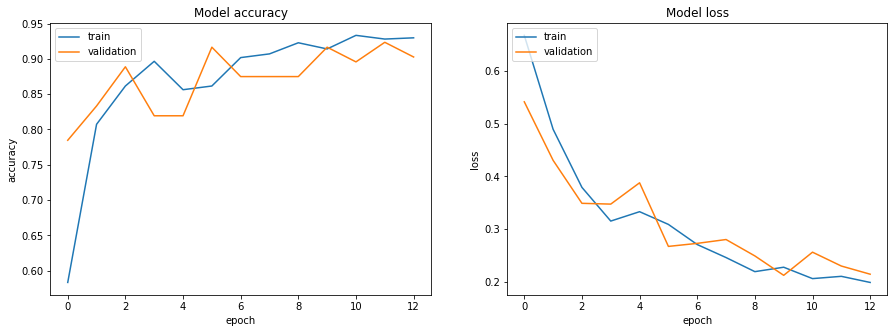

In [ ]:
model_vgg16.load_weights('/content/drive/MyDrive/Colab Notebooks/deeplearning/saved_models/cnn_model.hdf5')
plot_train_history(learning1)

In [ ]:
score1 = model_vgg16.evaluate(test_ds, verbose=1)
print(f'Model 2 VGG16 Loss: {score1[0]}, Accuracy: {score1[1]*100}')

50/50 [==============================] - 2s 28ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Model 2 VGG16 Loss: 0.0, Accuracy: 0.0


Finetune the model

In [ ]:
vgg16.trainable = True
model_vgg16.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
learning2 = model_vgg16.fit(train_ds, epochs = 20, validation_data = val_ds, callbacks=callbacks)

Epoch 1/20
18/18 [==============================] - ETA: 0s - loss: 0.2330 - accuracy: 0.9054
Epoch 1: val_accuracy did not improve from 0.92361
18/18 [==============================] - 21s 850ms/step - loss: 0.2330 - accuracy: 0.9054 - val_loss: 0.2066 - val_accuracy: 0.9097 - lr: 1.0000e-05
Epoch 2/20
18/18 [==============================] - ETA: 0s - loss: 0.1458 - accuracy: 0.9440
Epoch 2: val_accuracy improved from 0.92361 to 0.94444, saving model to /content/drive/MyDrive/Colab Notebooks/deeplearning/saved_models/cnn_model.hdf5
18/18 [==============================] - 12s 662ms/step - loss: 0.1458 - accuracy: 0.9440 - val_loss: 0.1399 - val_accuracy: 0.9444 - lr: 1.0000e-05
Epoch 3/20
18/18 [==============================] - ETA: 0s - loss: 0.1063 - accuracy: 0.9685
Epoch 3: val_accuracy improved from 0.94444 to 0.95833, saving model to /content/drive/MyDrive/Colab Notebooks/deeplearning/saved_models/cnn_model.hdf5
18/18 [==============================] - 15s 816ms/step - loss: 0

In [ ]:
model_vgg16.load_weights('/content/drive/MyDrive/Colab Notebooks/deeplearning/saved_models/cnn_model.hdf5')

In [ ]:
score2 = model_vgg16.predict(test_ds, verbose=1)
#print(f'Model 1 Vanilla Loss: {score1[0]}, Accuracy: {score1[1]*100}')
print(f'Model 2 VGG16 Loss: {score1[0]}, Accuracy: {score1[1]*100}')
print(f'Model 2 VGG16 Fine-tuned Loss: {score2[0]}, Accuracy: {score2[1]*100}')

50/50 [==============================] - 2s 15ms/step
Model 2 VGG16 Loss: 0.0, Accuracy: 0.0
Model 2 VGG16 Fine-tuned Loss: [0.99839944 0.00160054], Accuracy: [5.0130143e-06 1.0000000e+02]


In [ ]:
Y_pred = model_vgg16.predict(test_ds)

In [ ]:
predicted_class_indices=np.argmax(Y_pred,axis=1)

In [ ]:
labels = (train_ds.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [ ]:
filenames=test_ds.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results.to_csv("/content/drive/MyDrive/Colab Notebooks/deeplearning/Unkown_Image_pred.csv",index=False, header=["Epuret Moses Obuya", "2021/HD05/2291"])

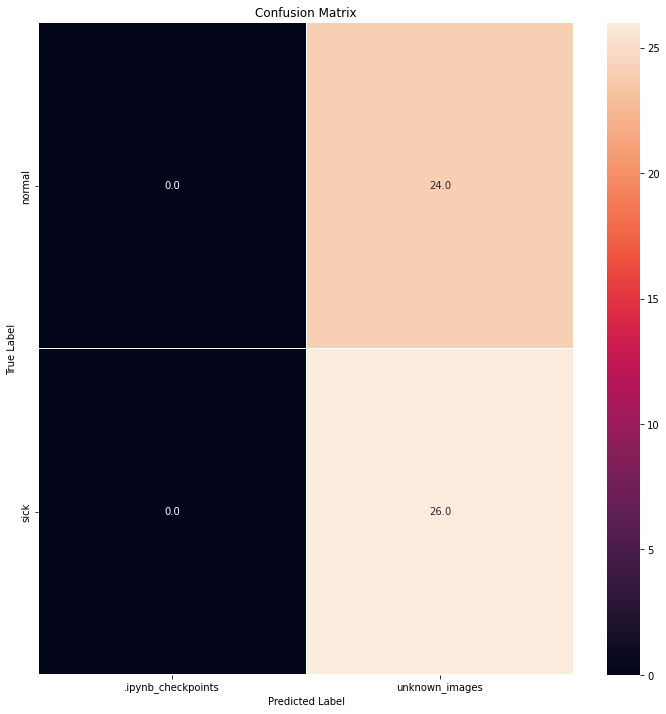

In [ ]:
y_pred = np.argmax(Y_pred, axis=1)
confusion_mtx = confusion_matrix(y_pred, test_ds.classes)
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.01,
            linecolor="white", 
            fmt= '.1f',ax=ax,)
sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(test_ds.class_indices)
ax.yaxis.set_ticklabels(image_class)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
report2 = classification_report(test_ds.classes, y_pred, target_names=image_class, output_dict=True)
df2 = pd.DataFrame(report2).transpose()
df2

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
normal,0.000000,0.000000,0.000000,0.000000
sick,1.000000,0.946188,0.972350,223.000000
accuracy,0.946188,0.946188,0.946188,0.946188
macro avg,0.500000,0.473094,0.486175,223.000000
weighted avg,1.000000,0.946188,0.972350,223.000000


In [ ]:
df2.to_csv(r'/content/drive/MyDrive/Colab Notebooks/deeplearning/dataset2.txt', header=True, index=True, sep = '\t', mode='a')